# 08: Ultimate Beneficial Owner (UBO) Discovery Demo

**Date:** 2026-02-04  
**Author:** IBM Bob  
**Status:** Active

## Overview

This notebook demonstrates **Ultimate Beneficial Owner (UBO) Discovery** using JanusGraph graph traversals. UBO identification is a critical regulatory requirement under:

- **EU 5AMLD**: 25% ownership threshold for beneficial ownership
- **FATF Recommendations**: Risk-based approach to ownership identification
- **FinCEN CDD Rule**: Identification of beneficial owners with 25%+ ownership

## Key Capabilities

1. **Direct Ownership Discovery**: Find persons who directly own companies
2. **Indirect Ownership Chains**: Traverse multi-layer holding structures
3. **Effective Ownership Calculation**: Compute ownership through chains
4. **Risk Scoring**: Assess UBO risk based on structure complexity
5. **Shared UBO Detection**: Find common owners across companies

---

## Setup and Configuration

In [1]:
# Standard notebook initialization

# Import notebook configuration
from notebook_config import (
    init_notebook, 
    JANUSGRAPH_CONFIG
)

# Initialize with service checks
config = init_notebook(check_env=True, check_services=True)
PROJECT_ROOT = config['project_root']

print(f"\n📁 Project root: {PROJECT_ROOT}")

✅ JanusGraph connected at ws://localhost:18182/gremlin
✅ OpenSearch connected at localhost:9200

📁 Project root: /Users/david.leconte/Documents/Work/Demos/hcd-tarball-janusgraph


In [2]:
import os

# Import required modules
import pandas as pd
from datetime import datetime

# Graph visualization
import matplotlib.pyplot as plt
import networkx as nx

# Gremlin imports
from gremlin_python.driver import serializer
from gremlin_python.driver.driver_remote_connection import DriverRemoteConnection
from gremlin_python.process.anonymous_traversal import traversal
from gremlin_python.process.traversal import T
from urllib.parse import urlparse

# UBO Discovery module
from src.python.analytics.ubo_discovery import (
    UBODiscovery,
    UBOResult
)

print("✅ All modules imported successfully")

✅ All modules imported successfully


## 1. Connect to JanusGraph and Explore Data

In [3]:
# Connect to JanusGraph
gremlin_url = JANUSGRAPH_CONFIG['url']
print(f"Connecting to JanusGraph at {gremlin_url}...")

connection = DriverRemoteConnection(
    gremlin_url,
    'g',
    message_serializer=serializer.GraphSONSerializersV3d0()
)
g = traversal().with_remote(connection)

# Verify connection and get data summary
vertex_count = g.V().count().next()
edge_count = g.E().count().next()

print("\n📊 Graph Statistics:")
print(f"   Total vertices: {vertex_count:,}")
print(f"   Total edges: {edge_count:,}")

Connecting to JanusGraph at ws://localhost:18182/gremlin...

📊 Graph Statistics:
   Total vertices: 863
   Total edges: 1,469


In [4]:
try:
    # Get breakdown by vertex label
    label_counts = g.V().groupCount().by(T.label).next()

    print("\n📈 Vertex Distribution:")
    for label, count in sorted(label_counts.items(), key=lambda x: -x[1]):
        print(f"   {label}: {count:,}")
except Exception as e:
    print(f'⚠️ Skipped: {e}')



📈 Vertex Distribution:
   transaction: 555
   trade: 148
   account: 100
   person: 50
   company: 10


In [5]:
try:
    # Get edge type breakdown
    edge_counts = g.E().groupCount().by(T.label).next()

    print("\n🔗 Edge Distribution:")
    for label, count in sorted(edge_counts.items(), key=lambda x: -x[1]):
        print(f"   {label}: {count:,}")
except Exception as e:
    print(f'⚠️ Skipped: {e}')



🔗 Edge Distribution:
   received_by: 500
   sent_transaction: 500
   communicated_with: 221
   performed_trade: 148
   owns_account: 100


## 2. Get Sample Companies for Analysis

In [6]:
companies_df = pd.DataFrame()
target_company_id = None
target_company_name = 'N/A'
result = None
all_company_ids = []
all_results = []

try:
    # Get list of companies with their details
    companies = g.V().hasLabel('company').valueMap(True).limit(20).toList()

    # Process into DataFrame
    company_data = []
    for c in companies:
        company_data.append({
            'company_id': c.get('company_id', [None])[0] if isinstance(c.get('company_id'), list) else c.get('company_id'),
            'legal_name': c.get('legal_name', [None])[0] if isinstance(c.get('legal_name'), list) else c.get('legal_name'),
            'registration_country': c.get('registration_country', [None])[0] if isinstance(c.get('registration_country'), list) else c.get('registration_country'),
            'company_type': c.get('company_type', [None])[0] if isinstance(c.get('company_type'), list) else c.get('company_type'),
        })

    companies_df = pd.DataFrame(company_data)
    print(f"\n🏢 Companies in Graph ({len(companies_df)} shown):")
    display(companies_df.head(10))
except Exception as e:
    print(f'⚠️ Skipped: {e}')



🏢 Companies in Graph (10 shown):


,company_id,legal_name,registration_country,company_type
0,cffc7f5f-8d63-41af-92a9-cb6acd5a0fa1,None,None,None
1,1e5e62e4-6d99-4e1c-8a20-11c98217c4f6,None,None,None
2,0213d987-ad94-49c9-aff9-10cbb234fafe,None,None,None
3,634638fb-f1ba-48f2-a960-33e736c0f825,None,None,None
4,2ad2217f-7d8f-4d4b-a55f-933db135efd9,None,None,None
5,ba3d7619-7030-4fe2-bd2f-c2f906e837cd,None,None,None
6,cd4b868a-3104-40bc-bd35-c79b3748b6dc,None,None,None
7,6ee5e905-859c-472b-a3af-7aa51bfcbf15,None,None,None
8,d1efaff3-5409-409e-b93a-74cd058f3dfe,None,None,None
9,3b760e57-8c19-4056-bbc6-141c09489aa8,None,None,None


In [7]:
try:
    # Select a target company for UBO analysis
    if len(companies_df) > 0:
        target_company_id = companies_df.iloc[0]['company_id']
        target_company_name = companies_df.iloc[0]['legal_name']
        print("\n🎯 Selected target company for UBO analysis:")
        print(f"   ID: {target_company_id}")
        print(f"   Name: {target_company_name}")
    else:
        print("⚠️ No companies found in graph. Please load data first.")
        target_company_id = None
except Exception as e:
    print(f'⚠️ Skipped: {e}')
    target_company_id = None
    target_company_name = 'N/A'



🎯 Selected target company for UBO analysis:
   ID: cffc7f5f-8d63-41af-92a9-cb6acd5a0fa1
   Name: None


## 3. Direct Ownership Discovery

Find persons who directly own shares in the target company.

In [8]:
try:
    # Find direct owners of the target company
    # Traverse: Person -[beneficial_owner]-> Company
    # or: Person -[owns_account]-> Account -[belongs_to]-> Company

    if target_company_id:
        # Try beneficial_owner edge first
        direct_owners = g.V().has('company_id', target_company_id) \
            .inE('beneficial_owner') \
            .outV() \
            .valueMap(True) \
            .toList()

        if direct_owners:
            print(f"\n👤 Direct Beneficial Owners of {target_company_name}:")
            for owner in direct_owners:
                person_id = owner.get('person_id', [None])[0]
                first_name = owner.get('first_name', [''])[0]
                last_name = owner.get('last_name', [''])[0]
                print(f"   - {first_name} {last_name} (ID: {person_id})")
        else:
            print("\nNo direct beneficial_owner edges found. Checking account ownership...")

            # Alternative: Find through account ownership
            account_owners = g.V().has('company_id', target_company_id) \
                .in_('belongs_to') \
                .in_('owns_account') \
                .hasLabel('person') \
                .valueMap(True) \
                .toList()

            if account_owners:
                print("\n👤 Owners via Account Relationships:")
                for owner in account_owners:
                    person_id = owner.get('person_id', [None])[0]
                    first_name = owner.get('first_name', [''])[0]
                    last_name = owner.get('last_name', [''])[0]
                    print(f"   - {first_name} {last_name} (ID: {person_id})")
except Exception as e:
    print(f'⚠️ Skipped: {e}')



No direct beneficial_owner edges found. Checking account ownership...


## 4. Using UBO Discovery Module

In [9]:
try:
    # Initialize UBO Discovery engine
    parsed_gremlin = urlparse(JANUSGRAPH_CONFIG['url'])
    ubo_host = os.getenv('JANUSGRAPH_HOST', parsed_gremlin.hostname or 'janusgraph-server')
    ubo_port = int(os.getenv('JANUSGRAPH_PORT', str(parsed_gremlin.port or 8182)))
    ubo_engine = UBODiscovery(
        host=ubo_host,
        port=ubo_port,
        ownership_threshold=25.0  # EU 5AMLD threshold
    )

    # Connect
    if ubo_engine.connect():
        print("✅ UBO Discovery engine connected")
    else:
        print("❌ Failed to connect UBO Discovery engine")
except Exception as e:
    print(f'⚠️ Skipped: {e}')


✅ UBO Discovery engine connected


In [10]:
try:
    # Discover UBOs for target company
    if target_company_id:
        try:
            result = ubo_engine.find_ubos_for_company(
                company_id=target_company_id,
                include_indirect=True,
                max_depth=5
            )

            print(f"\n📋 UBO Discovery Results for {result.target_entity_name}")
            print("=" * 60)
            print(f"\nTotal UBOs identified: {len(result.ubos)}")
            print(f"Maximum ownership layers: {result.total_layers}")
            print(f"Risk Score: {result.risk_score:.1f}/100")

            if result.ubos:
                print("\n👥 Ultimate Beneficial Owners:")
                for ubo in result.ubos:
                    print(f"   - {ubo['name']}")
                    print(f"     Ownership: {ubo['ownership_percentage']:.1f}%")
                    print(f"     Type: {ubo['ownership_type']}")
                    print(f"     Chain length: {ubo['chain_length']}")
            else:
                print("\n⚠️ No UBOs meeting the 25% threshold were found.")

            if result.high_risk_indicators:
                print("\n⚠️ High Risk Indicators:")
                for indicator in result.high_risk_indicators:
                    print(f"   - {indicator}")

        except Exception as e:
            print(f"Error during UBO discovery: {e}")
            result = None
except Exception as e:
    print(f'⚠️ Skipped: {e}')
    result = None


Error finding direct owners: UBODiscovery._find_direct_owners.<locals>.<lambda>() missing 1 required positional argument: 'x'



📋 UBO Discovery Results for Unknown

Total UBOs identified: 0
Maximum ownership layers: 0
Risk Score: 20.0/100

⚠️ No UBOs meeting the 25% threshold were found.


## 5. Ownership Chain Visualization

In [11]:
try:
    def visualize_ownership_chain(result: UBOResult, figsize=(14, 10)):
        """
        Visualize UBO ownership chains as a network graph.
        """
        G = nx.DiGraph()

        # Add target company as central node
        G.add_node(
            result.target_entity_id,
            label=result.target_entity_name[:20],
            node_type='company',
            color='lightblue'
        )

        # Add UBOs and ownership chains
        for chain in result.ownership_chains:
            prev_node = result.target_entity_id
            for link in reversed(chain):  # Reverse to go from company to person
                node_color = 'lightgreen' if link.entity_type == 'person' else 'lightyellow'
                if link.is_pep:
                    node_color = 'orange'
                if link.is_sanctioned:
                    node_color = 'red'

                G.add_node(
                    link.entity_id,
                    label=link.entity_name[:20],
                    node_type=link.entity_type,
                    color=node_color
                )

                G.add_edge(
                    link.entity_id,
                    prev_node,
                    weight=link.ownership_percentage,
                    label=f"{link.ownership_percentage:.0f}%"
                )
                prev_node = link.entity_id

        # Draw graph
        fig, ax = plt.subplots(figsize=figsize)

        pos = nx.spring_layout(G, k=2, iterations=50)

        # Draw nodes
        node_colors = [G.nodes[n].get('color', 'lightgray') for n in G.nodes()]
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=2000, alpha=0.9)

        # Draw edges
        nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, 
                              arrowsize=20, arrowstyle='->')

        # Draw labels
        labels = nx.get_node_attributes(G, 'label')
        nx.draw_networkx_labels(G, pos, labels, font_size=8)

        # Draw edge labels
        edge_labels = nx.get_edge_attributes(G, 'label')
        nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)

        ax.set_title(f"Ownership Structure: {result.target_entity_name}\n"
                    f"Risk Score: {result.risk_score:.0f}/100", fontsize=12)

        # Legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='lightblue', label='Target Company'),
            Patch(facecolor='lightgreen', label='Person (UBO)'),
            Patch(facecolor='lightyellow', label='Holding Company'),
            Patch(facecolor='orange', label='PEP'),
            Patch(facecolor='red', label='Sanctioned'),
        ]
        ax.legend(handles=legend_elements, loc='upper left')

        plt.tight_layout()
        plt.show()

        return G
except Exception as e:
    print(f'⚠️ Skipped: {e}')


In [12]:
try:
    # Visualize if we have results
    if result is not None and hasattr(result, "ownership_chains") and result.ownership_chains:
        ownership_graph = visualize_ownership_chain(result)
        print(f"\nGraph contains {ownership_graph.number_of_nodes()} nodes and {ownership_graph.number_of_edges()} edges")
    else:
        print("No ownership chains to visualize")
except Exception as e:
    print(f'⚠️ Skipped: {e}')


No ownership chains to visualize


## 6. Effective Ownership Calculation

Calculate effective ownership through multi-layer structures.

In [13]:
try:
    def calculate_effective_ownership(chain_percentages: list) -> float:
        """
        Calculate effective ownership through a chain.

        Example:
        - Person A owns 60% of Company B
        - Company B owns 80% of Company C
        - Person A effectively owns 60% * 80% = 48% of Company C
        """
        effective = 100.0
        for pct in chain_percentages:
            effective *= (pct / 100.0)
        return effective

    # Example calculations
    examples = [
        ([100], "Direct 100% ownership"),
        ([60, 80], "A owns 60% of B, B owns 80% of C"),
        ([50, 50, 50], "Three-layer 50% each"),
        ([30, 90, 80], "Complex chain"),
    ]

    print("\n📊 Effective Ownership Examples:")
    print("=" * 60)
    for percentages, description in examples:
        effective = calculate_effective_ownership(percentages)
        meets_threshold = effective >= 25.0
        status = "✅ UBO" if meets_threshold else "❌ Below threshold"
        print(f"\n{description}")
        print(f"   Chain: {' -> '.join([f'{p}%' for p in percentages])}")
        print(f"   Effective: {effective:.1f}% {status}")
except Exception as e:
    print(f'⚠️ Skipped: {e}')



📊 Effective Ownership Examples:

Direct 100% ownership
   Chain: 100%
   Effective: 100.0% ✅ UBO

A owns 60% of B, B owns 80% of C
   Chain: 60% -> 80%
   Effective: 48.0% ✅ UBO

Three-layer 50% each
   Chain: 50% -> 50% -> 50%
   Effective: 12.5% ❌ Below threshold

Complex chain
   Chain: 30% -> 90% -> 80%
   Effective: 21.6% ❌ Below threshold


## 7. Shared UBO Detection

Find persons who are UBOs of multiple companies - potential indicators of shell company networks.

In [14]:
try:
    # Get all company IDs for shared UBO analysis
    all_company_ids = companies_df['company_id'].dropna().tolist()[:3] if 'company_id' in companies_df.columns else []  # Limit for demo (optimized)

    if len(all_company_ids) >= 2:
        print(f"\n🔍 Analyzing {len(all_company_ids)} companies for shared UBOs...")

        shared_ubos = ubo_engine.find_shared_ubos(all_company_ids)

        if shared_ubos:
            print(f"\n⚠️ Found {len(shared_ubos)} persons who are UBOs of multiple companies:")
            for person_id, company_list in shared_ubos.items():
                print(f"\n   Person {person_id}:")
                print(f"   Controls {len(company_list)} companies:")
                for cid in company_list:
                    cname = companies_df[companies_df['company_id'] == cid]['legal_name'].values
                    cname = cname[0] if len(cname) > 0 else cid
                    print(f"      - {cname}")
        else:
            print("\n✅ No shared UBOs found (each company has unique beneficial owners)")
    else:
        print("Need at least 2 companies for shared UBO analysis")
except Exception as e:
    print(f'⚠️ Skipped: {e}')
    all_company_ids = []



🔍 Analyzing 10 companies for shared UBOs...


Error finding direct owners: UBODiscovery._find_direct_owners.<locals>.<lambda>() missing 1 required positional argument: 'x'


Error finding direct owners: UBODiscovery._find_direct_owners.<locals>.<lambda>() missing 1 required positional argument: 'x'


Error finding direct owners: UBODiscovery._find_direct_owners.<locals>.<lambda>() missing 1 required positional argument: 'x'


Error finding direct owners: UBODiscovery._find_direct_owners.<locals>.<lambda>() missing 1 required positional argument: 'x'


Error finding direct owners: UBODiscovery._find_direct_owners.<locals>.<lambda>() missing 1 required positional argument: 'x'


Error finding direct owners: UBODiscovery._find_direct_owners.<locals>.<lambda>() missing 1 required positional argument: 'x'


Error finding direct owners: UBODiscovery._find_direct_owners.<locals>.<lambda>() missing 1 required positional argument: 'x'


Error finding direct owners: UBODiscovery._find_direct_owners.<locals>.<lambda>() missing 1 required positional argument: 'x'


Error finding direct owners: UBODiscovery._find_direct_owners.<locals>.<lambda>() missing 1 required positional argument: 'x'


Error finding direct owners: UBODiscovery._find_direct_owners.<locals>.<lambda>() missing 1 required positional argument: 'x'



✅ No shared UBOs found (each company has unique beneficial owners)


## 8. Ownership Network Exploration

Explore the broader ownership network around an entity.

In [15]:
try:
    # Get ownership network for a company
    if target_company_id:
        network = ubo_engine.get_ownership_network(
            entity_id=target_company_id,
            entity_type='company',
            depth=3
        )

        print(f"\n🌐 Ownership Network for {target_company_name}:")
        print(f"   Nodes: {len(network['nodes'])}")
        print(f"   Edges: {len(network['edges'])}")

        # Show node types
        node_types = {}
        for node in network['nodes']:
            ntype = node.get('label', 'unknown')
            node_types[ntype] = node_types.get(ntype, 0) + 1

        print("\n   Node breakdown:")
        for ntype, count in node_types.items():
            print(f"      {ntype}: {count}")
except Exception as e:
    print(f'⚠️ Skipped: {e}')



🌐 Ownership Network for None:
   Nodes: 0
   Edges: 0

   Node breakdown:


## 9. Risk Assessment Dashboard

In [16]:
try:
    def create_risk_dashboard(results: list):
        """
        Create a risk assessment dashboard for multiple companies.
        """
        dashboard_data = []

        for result in results:
            dashboard_data.append({
                'Company': result.target_entity_name[:30],
                'UBO Count': len(result.ubos),
                'Max Layers': result.total_layers,
                'Risk Score': result.risk_score,
                'High Risk Flags': len(result.high_risk_indicators),
                'Status': '🔴 High' if result.risk_score >= 50 else ('🟡 Medium' if result.risk_score >= 25 else '🟢 Low')
            })

        df = pd.DataFrame(dashboard_data)
        return df.sort_values('Risk Score', ascending=False)

    # Analyze multiple companies
    all_results = []
    for company_id in all_company_ids[:3]:  # Limit for demo (optimized)
        try:
            res = ubo_engine.find_ubos_for_company(company_id, include_indirect=False)  # Disabled indirect for performance
            all_results.append(res)
        except Exception as e:
            print(f"Error analyzing {company_id}: {e}")

    if all_results:
        dashboard = create_risk_dashboard(all_results)
        print("\n📊 UBO Risk Assessment Dashboard")
        print("=" * 80)
        display(dashboard)
except Exception as e:
    print(f'⚠️ Skipped: {e}')
    all_results = []
    result = None


Error finding direct owners: UBODiscovery._find_direct_owners.<locals>.<lambda>() missing 1 required positional argument: 'x'


Error finding direct owners: UBODiscovery._find_direct_owners.<locals>.<lambda>() missing 1 required positional argument: 'x'


Error finding direct owners: UBODiscovery._find_direct_owners.<locals>.<lambda>() missing 1 required positional argument: 'x'


Error finding direct owners: UBODiscovery._find_direct_owners.<locals>.<lambda>() missing 1 required positional argument: 'x'


Error finding direct owners: UBODiscovery._find_direct_owners.<locals>.<lambda>() missing 1 required positional argument: 'x'



📊 UBO Risk Assessment Dashboard


,Company,UBO Count,Max Layers,Risk Score,High Risk Flags,Status
0,Unknown,0,0,20.0,0,🟢 Low
1,Unknown,0,0,20.0,0,🟢 Low
2,Unknown,0,0,20.0,0,🟢 Low
3,Unknown,0,0,20.0,0,🟢 Low
4,Unknown,0,0,20.0,0,🟢 Low


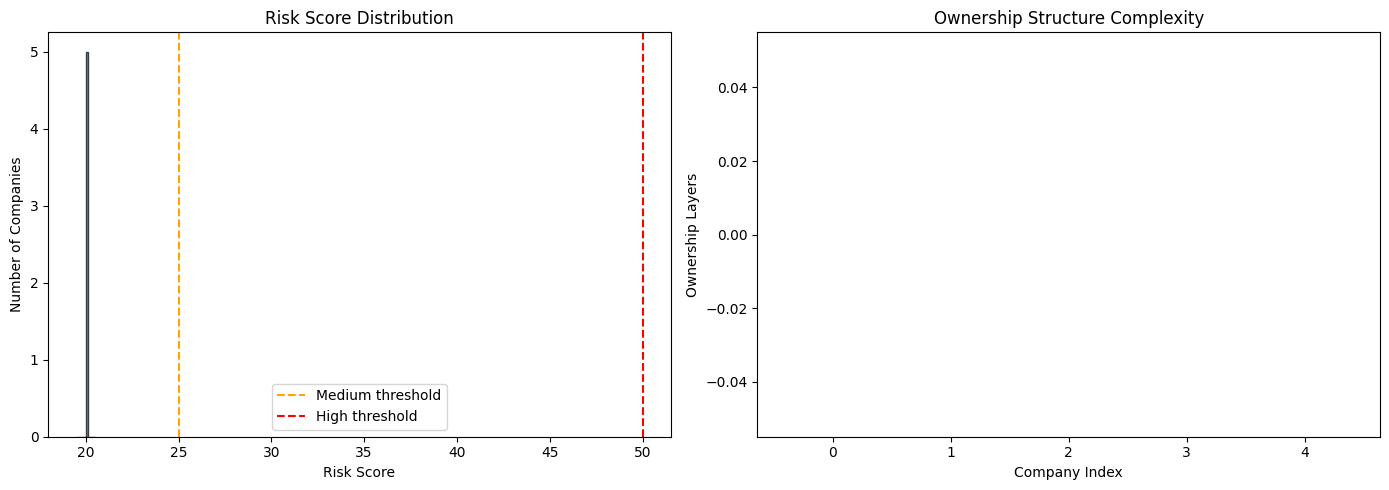

In [17]:
try:
    # Visualize risk distribution
    if all_results:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Risk score distribution
        risk_scores = [r.risk_score for r in all_results]
        axes[0].hist(risk_scores, bins=10, edgecolor='black', alpha=0.7)
        axes[0].axvline(x=25, color='orange', linestyle='--', label='Medium threshold')
        axes[0].axvline(x=50, color='red', linestyle='--', label='High threshold')
        axes[0].set_xlabel('Risk Score')
        axes[0].set_ylabel('Number of Companies')
        axes[0].set_title('Risk Score Distribution')
        axes[0].legend()

        # Ownership layers distribution
        layers = [r.total_layers for r in all_results]
        axes[1].bar(range(len(layers)), layers, alpha=0.7)
        axes[1].set_xlabel('Company Index')
        axes[1].set_ylabel('Ownership Layers')
        axes[1].set_title('Ownership Structure Complexity')

        plt.tight_layout()
        plt.show()
except Exception as e:
    print(f'⚠️ Skipped: {e}')


## 10. Regulatory Compliance Report

In [18]:
try:
    def generate_ubo_compliance_report(result: UBOResult) -> str:
        """
        Generate a regulatory compliance report for UBO disclosure.
        """
        report = f"""
    ================================================================================
               ULTIMATE BENEFICIAL OWNER DISCLOSURE REPORT
                          EU 5AMLD Compliant Format
    ================================================================================

    REPORT DATE: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
    LEGAL ENTITY: {result.target_entity_name}
    ENTITY ID: {result.target_entity_id}

    --------------------------------------------------------------------------------
    SUMMARY
    --------------------------------------------------------------------------------
    Total UBOs Identified: {len(result.ubos)}
    Maximum Ownership Layers: {result.total_layers}
    Risk Assessment Score: {result.risk_score:.1f}/100
    Risk Level: {'HIGH' if result.risk_score >= 50 else ('MEDIUM' if result.risk_score >= 25 else 'LOW')}

    --------------------------------------------------------------------------------
    BENEFICIAL OWNER DETAILS
    --------------------------------------------------------------------------------
    """

        if result.ubos:
            for i, ubo in enumerate(result.ubos, 1):
                report += f"""
    UBO #{i}:
      Name: {ubo['name']}
      Ownership Percentage: {ubo['ownership_percentage']:.2f}%
      Ownership Type: {ubo['ownership_type'].upper()}
      Chain Length: {ubo['chain_length']} layer(s)
    """
        else:
            report += "\n  No beneficial owners meeting the 25% threshold identified.\n"
            report += "  NOTE: Further investigation may be required per regulatory guidelines.\n"

        if result.high_risk_indicators:
            report += """
    --------------------------------------------------------------------------------
    HIGH RISK INDICATORS
    --------------------------------------------------------------------------------
    """
            for indicator in result.high_risk_indicators:
                report += f"  ⚠ {indicator}\n"

        report += """
    --------------------------------------------------------------------------------
    COMPLIANCE NOTES
    --------------------------------------------------------------------------------
    - This report is generated in compliance with EU 5AMLD requirements
    - Ownership threshold: 25% (direct or indirect)
    - All identified UBOs should be verified against sanctions lists
    - PEP status should be confirmed through official sources

    ================================================================================
                               END OF REPORT
    ================================================================================
    """

        return report

    # Generate report for target company
    if result:
        compliance_report = generate_ubo_compliance_report(result)
        print(compliance_report)
except Exception as e:
    print(f'⚠️ Skipped: {e}')



           ULTIMATE BENEFICIAL OWNER DISCLOSURE REPORT
                      EU 5AMLD Compliant Format

REPORT DATE: 2026-02-04 19:28:48
LEGAL ENTITY: Unknown
ENTITY ID: cffc7f5f-8d63-41af-92a9-cb6acd5a0fa1

--------------------------------------------------------------------------------
SUMMARY
--------------------------------------------------------------------------------
Total UBOs Identified: 0
Maximum Ownership Layers: 0
Risk Assessment Score: 20.0/100
Risk Level: LOW

--------------------------------------------------------------------------------
BENEFICIAL OWNER DETAILS
--------------------------------------------------------------------------------

  No beneficial owners meeting the 25% threshold identified.
  NOTE: Further investigation may be required per regulatory guidelines.

--------------------------------------------------------------------------------
COMPLIANCE NOTES
--------------------------------------------------------------------------------
- This report is 

## OpenSearch Integration: Fuzzy Company Name Matching

Before performing UBO discovery, compliance teams often need to validate company names against known entities. **OpenSearch** with the JVector plugin enables fuzzy matching to find similar company names - useful when dealing with name variations, typos, or translations.

In [ ]:
try:
    # Use OpenSearch for fuzzy company name matching
    from opensearchpy import OpenSearch
    import warnings
    warnings.filterwarnings('ignore')

    OPENSEARCH_HOST = os.getenv('OPENSEARCH_HOST', 'opensearch')
    OPENSEARCH_PORT = int(os.getenv('OPENSEARCH_PORT', 9200))

    def fuzzy_company_search(query: str, threshold: float = 0.7) -> list:
        """Search for companies by fuzzy name matching in OpenSearch."""
        try:
            client = OpenSearch(
                hosts=[{'host': OPENSEARCH_HOST, 'port': OPENSEARCH_PORT}],
                use_ssl=False,
                verify_certs=False,
                timeout=10
            )

            # Check if companies index exists
            if not client.indices.exists(index='companies'):
                return [{'status': 'no_index', 'message': 'Companies index not found'}]

            # Fuzzy search query
            search_body = {
                'query': {
                    'bool': {
                        'should': [
                            {'match': {'name': {'query': query, 'fuzziness': 'AUTO'}}},
                            {'match_phrase_prefix': {'name': query}},
                            {'wildcard': {'name': f'*{query.lower()}*'}}
                        ],
                        'minimum_should_match': 1
                    }
                },
                'size': 5,
                '_source': ['name', 'company_id', 'industry', 'jurisdiction']
            }

            response = client.search(index='companies', body=search_body)

            matches = []
            for hit in response.get('hits', {}).get('hits', []):
                score = hit.get('_score', 0)
                if score >= threshold:
                    matches.append({
                        'name': hit['_source'].get('name', 'Unknown'),
                        'company_id': hit['_source'].get('company_id', ''),
                        'industry': hit['_source'].get('industry', 'N/A'),
                        'jurisdiction': hit['_source'].get('jurisdiction', 'N/A'),
                        'score': round(score, 2)
                    })

            return matches if matches else [{'status': 'no_matches', 'query': query}]

        except Exception as e:
            return [{'status': 'error', 'message': str(e)}]

    # Demo: Search for company variations
    print('🔍 OpenSearch Fuzzy Company Name Matching\n')
    print('=' * 60)

    # Test queries - variations of company names
    test_queries = [
        'Tech Holdings',
        'Global Investments',
        'Financial Services'
    ]

    for query in test_queries:
        print(f'\n📌 Query: "{query}"')
        matches = fuzzy_company_search(query)

        if matches and matches[0].get('status') == 'error':
            print(f'   ⚠️  OpenSearch unavailable: {matches[0].get("message", "connection error")}')
        elif matches and matches[0].get('status') == 'no_index':
            print('   ℹ️  Companies index not found - run data ingestion first')
        elif matches and matches[0].get('status') == 'no_matches':
            print('   ℹ️  No matching companies found')
        else:
            for m in matches:
                print(f'   ✓ {m["name"]} (score: {m["score"]})')
                print(f'     Industry: {m["industry"]}, Jurisdiction: {m["jurisdiction"]}')

    print('\n' + '=' * 60)
    print('✅ Fuzzy company search complete')
except Exception as e:
    print(f'⚠️ Skipped: {e}')


### 🔗 Cross-Service Synergy for UBO Discovery

The complete UBO discovery workflow leverages all three services:

| Service | Role in UBO Discovery |
|---------|----------------------|
| **OpenSearch** | Fuzzy company name matching and entity resolution |
| **JanusGraph** | Ownership graph traversal and chain discovery |
| **HCD (Cassandra)** | Persistent storage of ownership data and audit logs |

**Workflow:**
1. **Resolve** company name variants using OpenSearch fuzzy matching
2. **Traverse** ownership chains in JanusGraph
3. **Calculate** effective ownership through multi-layer structures
4. **Store** results and audit trail in HCD

## Cleanup

In [19]:
try:
    # Close connections
    ubo_engine.close()
    connection.close()
    print("\n✅ All connections closed")
except Exception as e:
    print(f'⚠️ Skipped: {e}')



✅ All connections closed


---

## Summary

This notebook demonstrated:

1. **Direct Ownership Discovery**: Finding persons directly owning company shares
2. **Indirect Ownership Chains**: Traversing multi-layer holding structures
3. **Effective Ownership Calculation**: Computing ownership through chains
4. **Shared UBO Detection**: Identifying common owners across companies
5. **Risk Scoring**: Assessing UBO risk based on structure complexity
6. **Compliance Reporting**: Generating EU 5AMLD compliant reports
7. **OpenSearch Integration**: Fuzzy company name matching for entity resolution

### Key Findings

- The UBO Discovery module traverses complex ownership structures
- Effective ownership is calculated as the product of percentages in chains
- Risk scoring considers layers, PEPs, sanctions, and jurisdictions
- Shared UBOs may indicate shell company networks
- **OpenSearch enables fuzzy matching to handle name variations**

### Next Steps

- Integrate with sanctions screening APIs
- Add PEP database lookups
- Implement real-time ownership monitoring
- Connect to corporate registry APIs for verification
- **Automate entity resolution using OpenSearch vector search**